# Vortex Lattice Method: Effect of Aspect Ratio and Wing Shape on Lift

*By Jenna Osborn*

*MAE 6226 Spring 2017*

For this project, my goal was to develop a model that allows someone to quickly assess the wing shape and aspect ratio effect on the coefficient of lift for a particular style of wing. The only inputs required are...
1. Aspect Ratio
2. Number of panels in the chord direction
3. Number of panels in the span direction
4. Sweep back angle
5. Taper Ratio
6. Freestream velocity
7. Angle of Attack 

## Background

The study of finite wings is critical for the application of potential flow for real-life scenarios. The panel methods we have been using in class have been dealing with an inifinte 2D wing. 

A method that can be used to assess the lift on a 3D wing shape is the **Vortex Lattice Method** (VLM). The VLM panels the top surface of the wing into square or tetrahedrals. Once the top surface of the wing is panelled. A "bound" votex-sheet is placed 1/4 chord of the panel from the leading edge. Then trailing vortices are added to each end of the bound vortex sheet to give the effect of the trailing vortices. This creates a horse shoe vortex effect for a single panel. The circulation strength is assumed to be constant over the horseshoe vortex. 

Much like the 2D panel method, the circulation strength of the vortex sheet can be solved by a linear equation with the normal velocity components adding up to equal zero. The model below assumes a planar wing (no cambering) and that the wing is thin enough to ignore the the curvature to the cross-sectional airfoil, thus making it a 2D problem. 

### History of VLM 

Ludwig Prandtl and his collegues developed the first practical theory for a model for a finite wing. His model, the Lifting-Line theory is still used for early calculations for finite wing characteristics. His theory involves a single vortex sheet that runs along the span of the wing with two "free-trailing" vortex filaments at the ends of the vortex sheet like a giant horseshoe vortex. This can be expanded into an infinte number of these horseshoe vortices along the span of the wing so that there can be a varying strength circulation along the span as seen in Figure 1. 

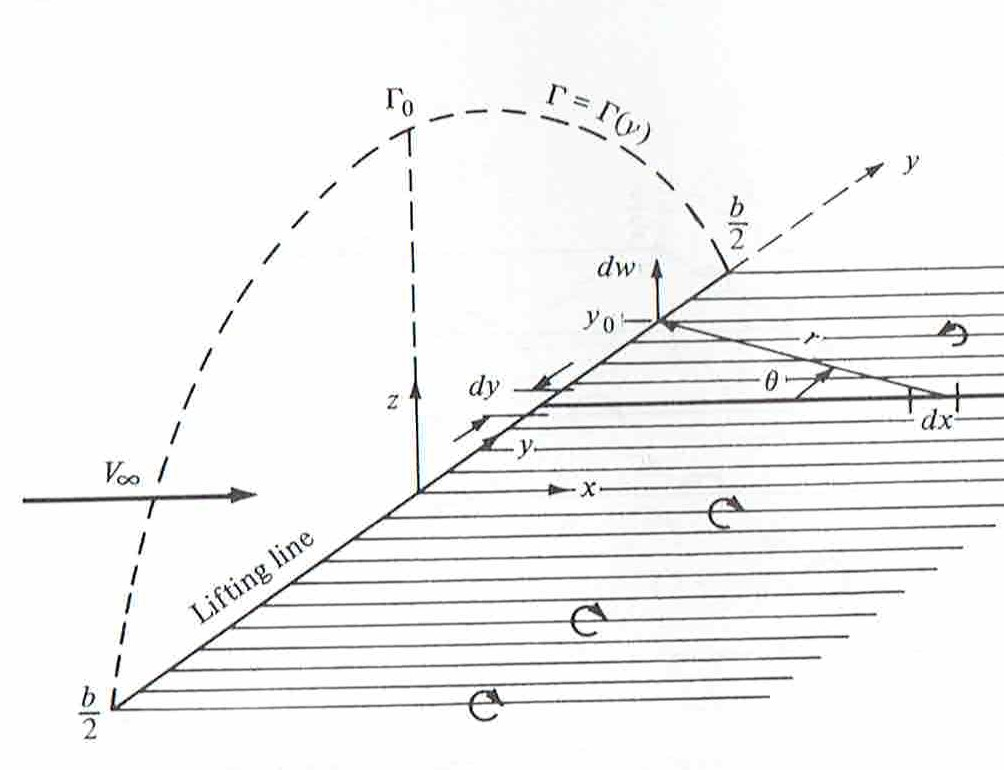

In [3]:
from IPython.core.display import Image
Image(filename = './Resources/LiftingLine.jpg')

This Lifting Line theory is a good representation of straight wings, but falls short for low aspect ratio wings, swept wings, and Delta wings. On these shapes a more complicated model is required for a better representation for the aerodynamic characteristics. One of these more complicated models is the VLM. 

### The mathematics behind VLM

The model follows the mathematics of the model outline in *Aerodynamics for Engineers* by Bertin and Smith. For a more in depth outline of the mathematics, the reader is referred to this book. 

Thie model approximates the the continuous distribution of bound vorticity of the wing as a finite number of horseshoe vortices. The geometry is broken up into panels on which these horseshoe vortices are placed. The bound vortex part of the horseshoe vortex is placed at 1/4 chord on the panel and aligned with the panel's local sweepback angle. The ends of the horseshoe vortices are aligned parallel to the y axis and extend to infinity.  

The normal velocity is required to be zero by this model and can be used to solve for the individual panel circulation strength. This boundary condition is applied to a control point on the panel which is located at the center of the panel in the x direction and 3/4 chord in the y direction as seen in Figure 2. 

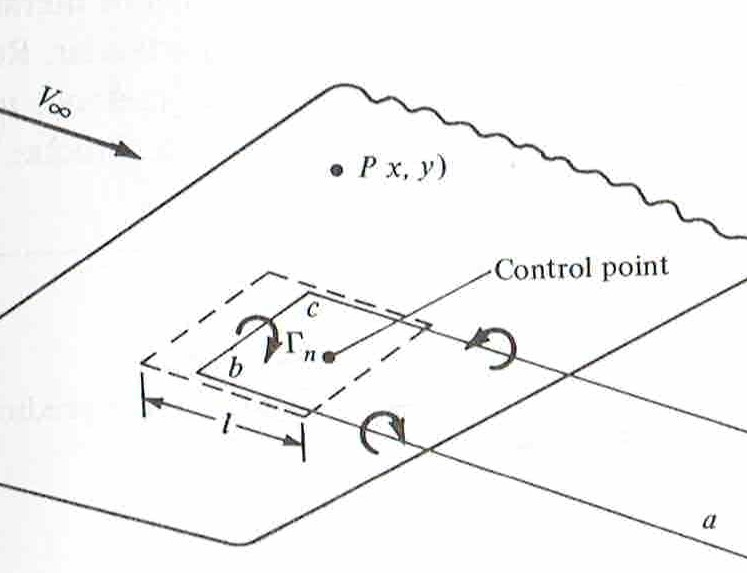

In [4]:
Image(filename = './Resources/Panel.jpg')

The angle of attack of the freestream velocity is the with the y axis as seen in Figure 3. 

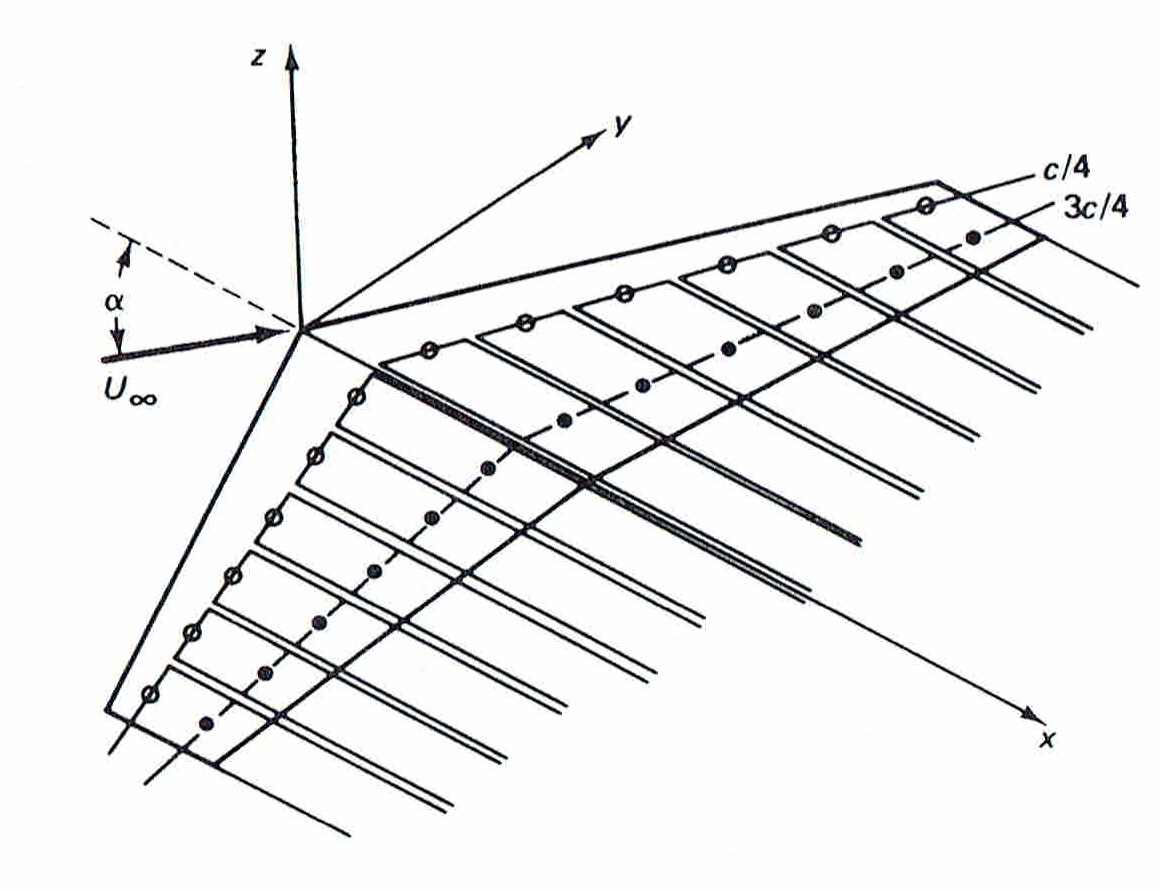

In [5]:
Image(filename = './Resources/AngleofAttack.jpg')

The model begins with the velocity induced by a vortex sheet of strength $\Gamma$ as given by the *Biot-Savart Law* 

$$dV = \frac{\Gamma(dl \times r)}{4\pi r^3}$$

For brevity purposes, following the model by Bertin and Smith the normal velocity induced on panel *m* by the horseshoe vortex on panel *n* is given by

$$ w_{m,n} = \frac{\Gamma_{n}}{4\pi} \left\{ \frac{1}{(x_m-x_{1n})(y_m-y_{2n}) -(x_m -x_{2n})(y_m-y_{1n})} \left[ \frac{(x_{2n}-x_{1n})(x_m-x_{1n})+(y_{2n}-y_{1n})(y_m - y_{1n})}{\sqrt{(x_m-x_{1n})^2+(y_m-y_{1n})^2}} - \frac{(x_{2n}-x_{1n})(x_m-x_{2n})-(y_{2n}-y_{1n})(y_m-y_{1n})}{\sqrt{(x_m-x_{1n})^2+(y_m-y_{2n})^2}} \right] +\frac{1.0}{y_{1n}-y_m} \left[ 1.0 + \frac{x_m-x_{1n}}{\sqrt{(x_m-x_{1n})^2 + (y_m-y_{1n})^2}} \right] - \frac{1.0}{y_{2n}-y_m} \left[ 1.0 + \frac{x_m-x_{2n}}{\sqrt{(x_m-x_{2n})^2 +(y_m-y_{2n})^2}} \right] \right\}  $$

In this equation $(x_m, y_m)$ are the control point coordinates on panel *m*, $(x_{1n}, y_{1n})$ is the left endpoint on of the vortex sheet on panel *n*, and $(x_{2n}, y_{2n})$ is the right endpoint on the vortex sheet on panel *n*.

To find the normal velocity induced at control point on panel *m*, we have to sum up all the panel vortex sheet contributions. The wing is divided so that there are N panels on one side of the panel, so we need to sum over both sides, i.e *2N*. 

$$ w_{m} = \displaystyle\sum_{n=1}^{2N} w_{m,n} $$

The linear equation we need to solve for the circulation strengths is... 
$$ w_{m} + U_{\infty} sin\alpha = 0 $$

The nice thing about this model is that the normal velocity only has to be solved for on one side of the wing. The model assumes wing symmetry, so *m* only has to be summed to N. And there are only N unknowns. After the circulation is solved for, when calculating the lift, the effect of the circulation can be doubled to account for both sides of the wing. However, *n* has to be summed over both sides of the panels because the port side panels still effects the normal velocity on the starboard panels. 


## Development of the Model

The model below is comprimised of small functions that are used to create the larger model called **VLM**. The model than can be used with the imputs as stated above for an assessment of the lift.

#### Importing the Necessary Libraries 

In [6]:
import numpy
from scipy import linalg 
from matplotlib import pyplot


#embed the figures inline with the text
%matplotlib inline

### Geometry and Associated Panels 

The first function needed for completion of the model is to take the inputted values of Aspect Ratio (AR), number of panels in the chord direction (nchord), number of panels in the spanwise direction (nspan), sweep angle of the leading edge of the wing (sweepangle), the taper ratio of the wing if a tapered wing (tapratio), and Type of wing and then to return a set of points for the panels on the wing.

This model assumes symmetry about the middle of the wing, so only one of the sides needs to be discretized into panels and calculated. The points can be reflected about the y axis for the other half. The resulting lift can be doubled at the end. We are going to define the starboard half of the wing and we will deal with the port side half later. 

The different Types of wings are dealt with separately. 

1. **DELTA WING**
    - The delta wing is assumed to be a triangle wing. The panels are rectilinearly defined. Due to the shape of the triangle, each row will have a different number of panels. So, only the nchord variable is necessary to define. The nspan, sweepangle, tapratio can all be left as 0. 

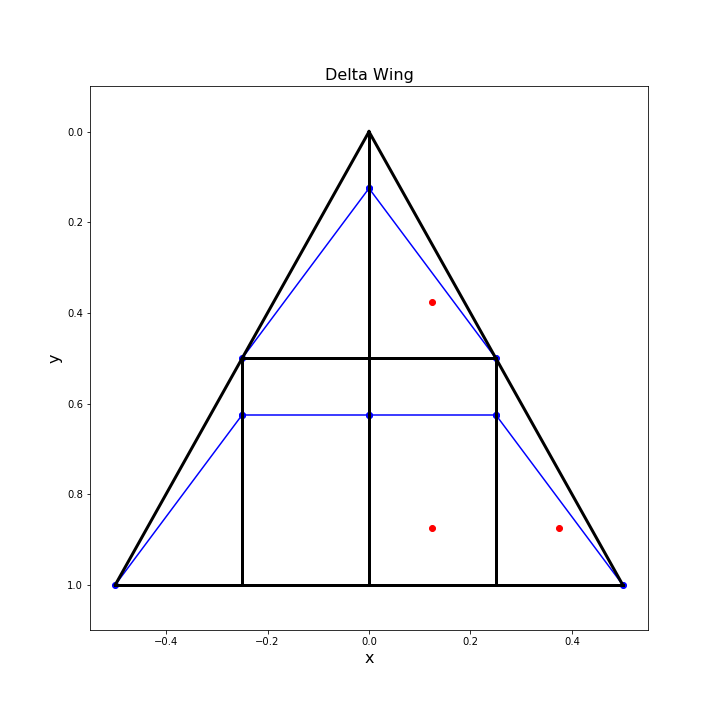

In [7]:
Image(filename='./Resources/DeltaWing.png')

2. **CONSTANT CHORD**
    - The  constant chord model is assumed to have a constant chord throughout the span of the wing. This chord is calculated from the inputted Aspect ratio. The nchord, nspan, and sweepangle all can be varied as an input. The tapratio is not necessary in this model because the ratio of the inside edge to the outide edge is always 1. This input can be left as 0.

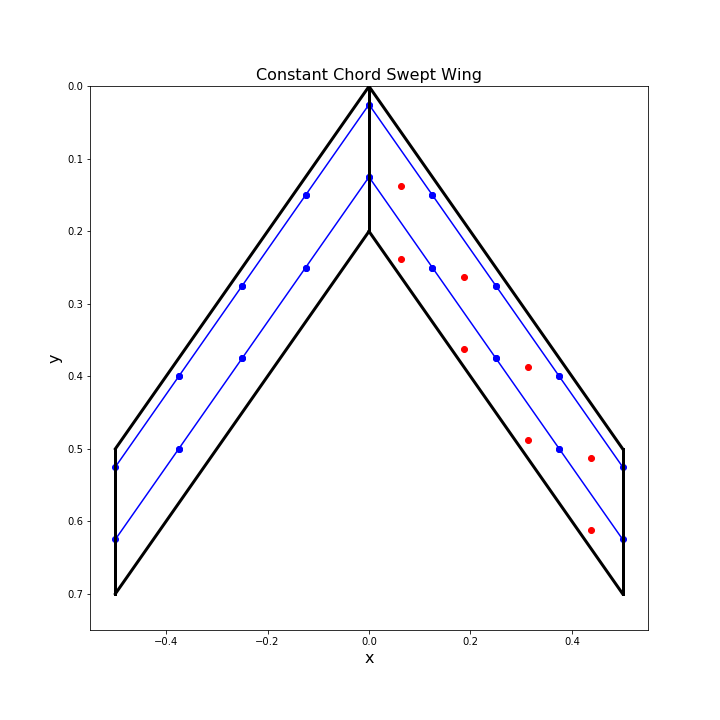

In [8]:
Image(filename='./Resources/Constant_Chord.png')

3. **TAPERED**
    - The tapered model allows the input to vary the ratio of the wing to the outside egde chord length to the inside edge chord length. This is a more realistic version of different set of wings. The nspan, nchord, sweepangle, and tapratio can be set by the input to varying values. 

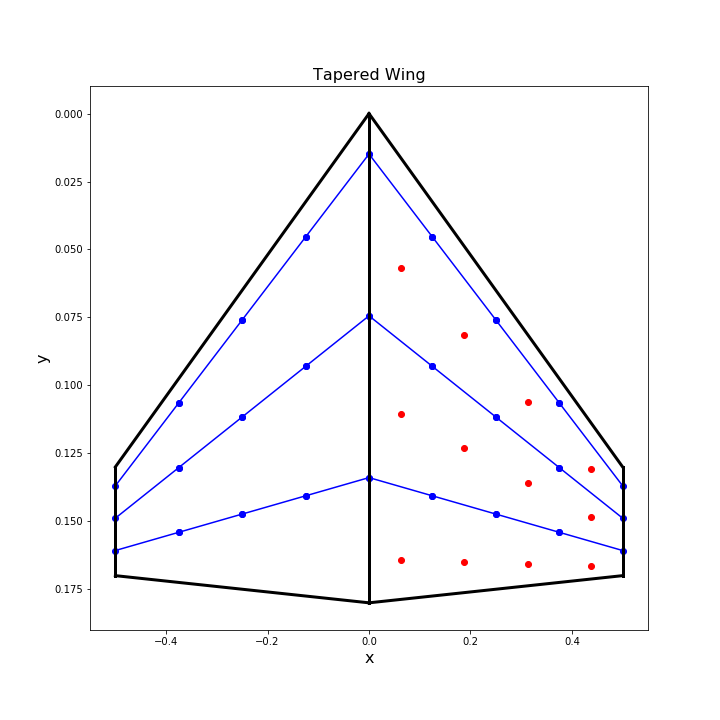

In [9]:
Image('./Resources/Tapered.png')

In [10]:
def panel_coordinates(AR, nchord, nspan, sweepangle, tapratio, Type):
    """ 
    Defines the two x-coordinates and the four y-coordinates
    of the panel to calculate the vortex lattice method. 
    
    Parameters
    ----------
    AR: float
        Aspect Ratio of the wing
    nchord: int
        Number of panels in the chord direction 
    nspan: int
        Number of panels in the span direction 
    sweepangle: float
        The sweep angle of the leading edge of the wing (in degrees)
    tapratio: float 
        The ratio of the width on the outer edge of the wing to 
        the width of the middle of the wing.
    Type: String
        Style of wing, three options: 'Delta', 'Constant Chord', 'Tapered'
    
    Returns 
    -------
    panelsx: 2D Numpy array 
        The x-coordinates for the panels 
    panelsy: 2D Numpy Array
        The y-coordinates of the panels 
    N: int 
        The number of panels 
    cav: float
        The average chord of the wing 
    """
    
    n= 0 # counter for number of rows
    
    if Type == 'Delta':
        N = nchord**2
        for i in range(nchord):
            N -= i
        
        width = 1.0
        cav = width/AR
        height = 2.0*width/AR
        
        x  = numpy.linspace(0.0, 0.5*width, nchord+1)
        y =  numpy.linspace(0.0, height, nchord+1)
        
        X,Y = numpy.meshgrid(x,y)
        
        panelsx = numpy.empty((N, 2), dtype = float)
        panelsy = numpy.empty((N, 4), dtype = float)
        n=0
        for i in range(nchord): 
            for j in range(i+1): 
                if i == j: 
                    panelsx[n, 0], panelsx[n, 1] = X[i,j], X[i, j+1]
                    panelsy[n, 0] = Y[i,j]
                    panelsy[n,1], panelsy[n,2], panelsy[n,3] = Y[i+1,j], Y[i+1, j], Y[i+1, j]
                else: 
                    panelsx[n,0], panelsx[n,1] = X[i,j], X[i, j+1]
                    panelsy[n,0], panelsy[n,1] = Y[i, j], Y[i, j+1]
                    panelsy[n,2], panelsy[n,3] = Y[i+1, j], Y[i+1,j+1]
                n = n+1
                
    elif Type == 'Constant Chord':
        width =1.0
        cav = width/AR
        
        slope= 0.0
        b = 0.0
       
        a = sweepangle*numpy.pi/180.0
        slope, b = numpy.polyfit([0.0,0.5*width], [0.0, 0.5*width*numpy.tan(a)], 1)

        N  = nchord*nspan
        ydev = cav/nchord

        panelsx = numpy.empty((N,2), dtype = float)
        panelsy = numpy.empty((N,4),dtype = float)
        
        x = numpy.linspace(0.0, 0.5*width, nspan+1)
        y = slope*x+b
        
        n = 0
        for i in range(nchord):
            for j in range(nspan): 
                panelsx[n,0], panelsx[n,1] = x[j], x[j+1]
                panelsy[n,0], panelsy[n,1] = y[j]+ydev*i, y[j+1]+ydev*i
                panelsy[n,2], panelsy[n,3] = y[j]+ydev*(i+1), y[j+1]+ydev*(i+1)
                n= n+1
        
    elif Type == 'Tapered':
        width = 1.0
        x = numpy.linspace(0.0, 0.5*width, nspan+1)
        cav = width/AR
        h1 = 2.0*cav/(1+tapratio)
        h2 = tapratio*h1
        N = nchord*nspan
        sweepangle = sweepangle*numpy.pi/180.0
         
   
        ydiff1 = h1/(nchord+1)
        ydiff2 = h2/(nchord+1)
         
        
         
        panelsx = numpy.empty((N, 2), dtype =float)
        panelsy = numpy.empty((N, 4), dtype =float)
         
        m = numpy.empty(nchord+1, dtype = float)
        b = numpy.empty(nchord+1, dtype = float)
         
        for i in range(nchord+1):
            m[i], b[i] = numpy.polyfit([0.0, 0.5*width], [0.0+i*ydiff1, 0.5*width*numpy.tan(sweepangle)+i*ydiff2],1)
        n = 0
        for i in range(nchord):
            for j in range(nspan):
                panelsx[n,0], panelsx[n,1] = x[j], x[j+1]
                panelsy[n,0], panelsy[n,1] = m[i]*x[j]+b[i], m[i]*x[j+1]+b[i]
                panelsy[n,2], panelsy[n,3] = m[i+1]*x[j]+b[i+1], m[i+1]*x[j+1]+b[i+1]
                n += 1
    else:
        print('Invalid Type, Please Pick "Delta", "Constant Chord", or "Tapered"')

     

    return panelsx, panelsy, N, cav

The next set of functions to define is calculating the bound vortex sheet end points and the control points for each panel. The triangle panels have to be handled differently than the square or trapezoidal panels. The bound vortex endpoints are calculated from the 1/4 chord on one side of the triangle point on the other side. The control point is still in the middle of the panel and 3/4 chord from the top of the panel as if it were a square. A visual can be seen in Figure 4. 

In [11]:
def triangle_panels(x1, x2, y1, y2, y3, y4):
    """
    Defines the control points on the triangle points
    
    Parameters
    ----------
    x1,  x2,: float 
        The x-coordinates of the panels 
    y1, y2, y3, y4: float
        The y-coordinates of the corners of the panels 
    
    Returns
    -------
    xcp: float 
        x-coordinate of the control point 
    ye1, ye2: float
        The y-coordinates of the endpoints of the vortex filament 
    ycp: float
        y-coordinate of the control points 
    """
    xcp = 0.5*(x2-x1)+x1
    
    ye1 = 0.25*(y3-y1)+y1
    ye2 = y4
    
    m, b = numpy.polyfit([x1,x2], [0.75*(y3-y1)+y1, 0.75*(y4-y2)+y2], 1)
    ycp = 0.75*(y3-y1)+y1
    #ycp = m*xcp+b
    
    return xcp, ye1, ye2, ycp

def control_pts(x1,x2, y1, y2, y3, y4): 
    xe1, xe2 = x1, x2    
    if (y2 == y4):
        xcp, ye1, ye2, ycp = triangle_panels(x1,x2,y1,y2, y3, y4)
    
    else: 
        xcp = (x2-x1)/2 + x1
        ye1 = 0.25*(y3-y1)+y1
        ye2 = 0.25*(y4-y2)+y2
        m,b = numpy.polyfit([x2, x1], [0.75*(y4-y2)+y2, 0.75*(y3-y1)+y1], 1)
        ycp = m*xcp + b
        
    
    return xe1, xe2, xcp, ye1, ye2, ycp



Now it is time to define the class **Panels**. This has been modified from our class panels to store the endpoint of the panels's bound vortex and the control points. We are only defining the starboard panels with this class. We will write another function for the port side panels later. 

In [12]:
class Panels:
    """
    Contains the information regarding the panel 
    """
    def __init__(self,x1, x2, y1, y2, y3, y4):
        """
        Initializes the panel
        
        Paratmeters
        -----------
        x1, x2: floats
            x-coordinates of the sides of the panels 
        y1,y2,y3,y4: floats
            y-coordinates of the corners of the panels 
        """
        m=0
        b=0
        self.xe1, self.xe2, self.xcp, self.ye1, self.ye2, self.ycp = control_pts(x1,x2,y1,
                                                                              y2,y3,y4)
        

def define_panels(x,y, N):
    """
    Defines the panels from the inputs from panel_coordinates 
    
    Parameters
    ----------
    x: 2D numpy array
        x-coordinates of the panels 
    y: 2D numpy array
        y-coordinates of the panels 
        
    Returns
    -------
    panels: Panel Object
        Panels of control points 
    """
    panels = numpy.empty(N, dtype = object)
    
    for i in range(N):
            panels[i]= Panels(x[i,0], x[i,1],
                                     y[i,0], y[i,1], y[i,2], y[i, 3] )
            
    return panels

Despite not having to calculate the effect of the whole wing, we still need to calculate the vortex sheet effects on a particular control point on both the starboard and port side wing.

We just need to define the port side vortex sheet endpoints which are just reflected about the y axis. This requires that the points be indexed from left to right.

We need to define a new class of **Port_Panels** that carries this information for us to be used later.

In [13]:
class Port_Panels:
    """
    Defines the Portside panel points from the starboard side points
    """
    def __init__(self, panels):
        """
        Initializing the port side panels 
        
        Parameters
        ----------
        panels: Panel objects 
            The starboard side panels 
        
        Returns
        -------
        Port_panels: Panel object
            The port side panels 
        """
        
        self.xe1, self.xe2 = -panels.xe2, -panels.xe1
        self.ye1, self.ye2 = panels.ye2, panels.ye1

Now we need to calculate the normal velocity caused be the panel vortex sheets. So we take the need to calculate the velocity induced at panel m's control point by the vortex sheet on panel n.

The function of **singularity_matrix** does that for us.

In [14]:
def singularity_matrix(panel, port_panel,N):
    """
    Defines the normal velocity matrix
    
    Parameters
    ----------
    panels: Panel objects 
        The starboard panels that are required for calculating the effects on 
    port-panel: Port_panel Object 
        The port side panels that are used for calculating the effect on the panels 
    
    Returns 
    -------
    w: 2D numpy array 
        The normal velocities induced by the horseshoe vortices 
    w_s: 2D numpy array
        The normal velocity induced by starboard panels
    w_p: 2D numpy array 
        The normal velocity induced by the port side panels 
    
    """
    w = numpy.empty((N,N), dtype = float)
    w_s = numpy.empty((N,N), dtype =float)
    w_p = numpy.empty((N,N), dtype =float)

    
    for m in range(N):
        for n in range(N):
            w_s[m, n] = ( 1.0/((panel[m].ycp -panel[n].ye1)*(panel[m].xcp-panel[n].xe2)- 
             (panel[m].ycp-panel[n].ye2)*(panel[m].xcp-panel[n].xe1)) * (((panel[n].ye2-panel[n].ye1)*(panel[m].ycp-panel[n].ye1) +
              (panel[n].xe2-panel[n].xe1)*(panel[m].xcp-panel[n].xe1))/numpy.sqrt((panel[m].ycp-panel[n].ye1)**2 +(panel[m].xcp-panel[n].xe1)**2)
             - ((panel[n].ye2-panel[n].ye1)*(panel[m].ycp -panel[n].ye2 ) +(panel[n].xe2 - panel[n].xe1)*(panel[m].xcp-panel[n].xe2))/ 
               numpy.sqrt((panel[m].ycp-panel[n].ye2)**2 +(panel[m].xcp - panel[n].xe2)**2)) 
             + 1.0/(panel[n].xe1-panel[m].xcp)*(1.0 + (panel[m].ycp-panel[n].ye1)/numpy.sqrt((panel[m].ycp-panel[n].ye1)**2+(panel[m].xcp-panel[n].xe1)**2)) 
             - 1.0/(panel[n].xe2-panel[m].xcp)*(1.0 + (panel[m].ycp-panel[n].ye2)/numpy.sqrt((panel[m].ycp-panel[n].ye2)**2+(panel[m].xcp-panel[n].xe2)**2))
               )
            w_p[m, n] = ( 1.0/((panel[m].ycp -port_panel[n].ye1)*(panel[m].xcp-port_panel[n].xe2)- 
             (panel[m].ycp-port_panel[n].ye2)*(panel[m].xcp-port_panel[n].xe1)) * (((port_panel[n].ye2-port_panel[n].ye1)*(panel[m].ycp-port_panel[n].ye1) +
              (port_panel[n].xe2-port_panel[n].xe1)*(panel[m].xcp-port_panel[n].xe1))/numpy.sqrt((panel[m].ycp-port_panel[n].ye1)**2 +(panel[m].xcp-port_panel[n].xe1)**2)
             - ((port_panel[n].ye2-port_panel[n].ye1)*(panel[m].ycp -port_panel[n].ye2 ) +(port_panel[n].xe2 - port_panel[n].xe1)*(panel[m].xcp-port_panel[n].xe2))/ 
               numpy.sqrt((panel[m].ycp-port_panel[n].ye2)**2 +(panel[m].xcp - port_panel[n].xe2)**2))  
             + 1.0/(port_panel[n].xe1-panel[m].xcp)*(1.0 + (panel[m].ycp-port_panel[n].ye1)/numpy.sqrt((panel[m].ycp-port_panel[n].ye1)**2+(panel[m].xcp-port_panel[n].xe1)**2)) 
            - 1.0/(port_panel[n].xe2-panel[m].xcp)*(1.0 + (panel[m].ycp-port_panel[n].ye2)/numpy.sqrt((panel[m].ycp-port_panel[n].ye2)**2+(panel[m].xcp-port_panel[n].xe2)**2)) 
                       )
    w = w_s + w_p
    
    return w,w_s,w_p

In order to calculate the effect of the freestream effects the normal velocity we need to set up the right hand side just as we did with the panel methods. However, this model is assuming a planar wing so there the right hand side will be the same number repeated because it will be the same on all the panels

In [15]:
class Freestream: 
    """ 
    Defines the freestream conditions
    """
    def __init__(self, u_inf, alpha):
        """
        Initializes the Freestream object. 
        
        Parameters
        ----------
        u_inf = float
            The freestream velocity magnitude
        alpha: float
            The angle of the free stream with the y axis (in degrees)
            
        Returns
        -------
        freestream: freestream object
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0
        
        
        
def build_rhs(freestream, N):
    """
    Builds the right hand side of the linear equation to solve. 
    
    Parameters
    ----------
    freestream: freestream object
        The information contained about the freestream velocity
    N: int
        number of panels 
    
    Returns
    -------
    b: 2D numpy array
        The freestream contribution to the normal velocity 
    """
    b = -numpy.ones(N)*4*numpy.pi*freestream.u_inf*numpy.sin(freestream.alpha)
    
    return b

Now we can write a function that can calculate the lift coefficent.

In [16]:
def calculate_lift(panels, gammas, freestream, cav, N):
    """
    Calculates the lift from the calculated from the calculated circulation 
    
    Parameters
    ----------
    panels: panel objects 
        The panels that the circulation was calculated on 
    gammas: 2D numpy array
        The circulation strengths on the associated panels 
    freestream: freestream object 
        The information regarding the freestream velocity 
    cav: float
        Average chord of the wing
    N: int 
        number of panels 
    
    Returns
    -------
    Cl: float 
        The lift coefficient 
    """
    Cl = 0.0
    for i in range(N):
        Cl += 2.0*gammas[i]*(panels[i].xe2-panels[i].xe1)/(0.5*freestream.u_inf*cav)
        
    return Cl

Now we can combine all of the steps into one process and one function called **VLM**.

In [29]:
def VLM(AR,nchord, nspan, sweepangle,tapratio, Type, u_inf, AoA):
    """
    Calculated the lift coefficient from a given wing geometry 
    
    Parameters
    ----------
    AR: float
        Aspect Ratio
    nchord: float 
        Number of panels in chord direction 
    nspan: float 
        Number of panels in the span direction 
    sweepangle: float
        Sweepangle
    tapratio: float
        Taper ratio
    Type: String 
        Type of wing: 'Delta', 'Constant Chord', or 'Tapered'
    u_inf: float 
        freestream velocity magnitude 
    alpha: float 
        The angle of the freestream velocity with the y axis. 
    
    Returns
    -------
    Cl: float
        Coefficient of Lift
    """
# Calculating the x and y-coordinates of the individual panels
    x,y, N, cav = panel_coordinates(AR, nchord, nspan, sweepangle, tapratio, Type)


    panels = define_panels(x,y,N)


    # Defining the port panels 
    port_panels = numpy.empty(N, dtype=object)

    for i in range(N):
        port_panels[i] = Port_Panels(panels[i])
    
    w,w_s,w_p = singularity_matrix(panels, port_panels,N)
    
    freestream = Freestream(u_inf, AoA)

    b = build_rhs(freestream, N)

    gammas = numpy.linalg.solve(w, b)


    Cl = calculate_lift(panels, gammas, freestream, cav ,N)
    # compute the chord and lift coefficient
    #print('lift coefficient: CL = {:0.6f}'.format(Cl))
    
    return Cl


## Validation of Model 

First test fror this model is to see if the simulation matches the book results by Bertin and Smith. 

For AR = 5.0 and angles of attack varyinf from 0 to 10, with 4 panels in the spanwise direction and 1 in the chordwise direction, and a sweep angle of 45.0

In [18]:
# Wing Characteristics 
AR = 5.0
nchord = 1
nspan = 4 
tapratio = 0
sweepangle = 45.0
Type = 'Constant Chord'

# Freestream Conditions
u_inf = 1.0
alpha  = numpy.linspace(0, 10.0, 11)

# Calculating Lift coefficient 
Cl = numpy.empty(11, dtype =float)

for i in range(11): 
    print('Angle of Attack: ', alpha[i], ' Degrees')
    Cl[i] = VLM(AR, nchord, nspan, sweepangle, tapratio, Type,
               u_inf, alpha[i])


Angle of Attack:  0.0  Degrees
lift coefficient: CL = 0.000000
Angle of Attack:  1.0  Degrees
lift coefficient: CL = 0.060110
Angle of Attack:  2.0  Degrees
lift coefficient: CL = 0.120202
Angle of Attack:  3.0  Degrees
lift coefficient: CL = 0.180257
Angle of Attack:  4.0  Degrees
lift coefficient: CL = 0.240257
Angle of Attack:  5.0  Degrees
lift coefficient: CL = 0.300184
Angle of Attack:  6.0  Degrees
lift coefficient: CL = 0.360019
Angle of Attack:  7.0  Degrees
lift coefficient: CL = 0.419745
Angle of Attack:  8.0  Degrees
lift coefficient: CL = 0.479343
Angle of Attack:  9.0  Degrees
lift coefficient: CL = 0.538795
Angle of Attack:  10.0  Degrees
lift coefficient: CL = 0.598083


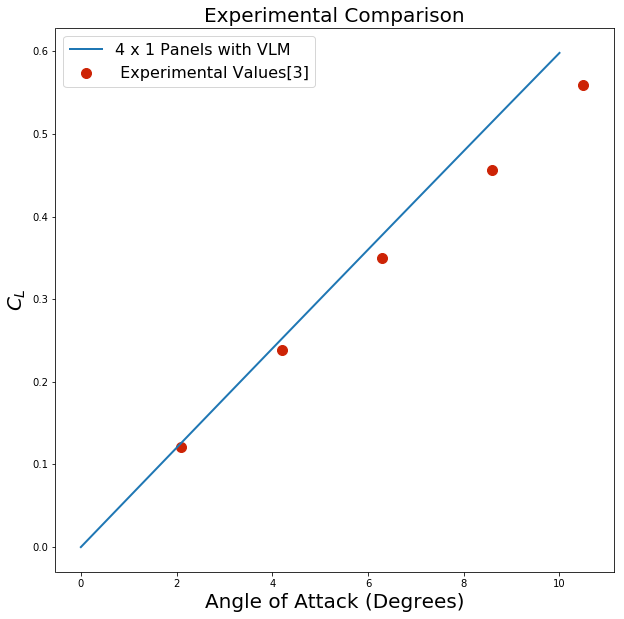

In [19]:
# Importing the experimental result 
Exp = numpy.genfromtxt('./Resources/ExperimentalValues.csv',
                                    delimiter = ',')
alpha_exp = Exp[:,0]
Cl_exp = Exp[:,1]

# Plotting the results 
pyplot.figure(figsize = (10,10))
pyplot.title('Experimental Comparison', fontsize = 20)
pyplot.xlabel('Angle of Attack (Degrees)', fontsize =20)
pyplot.ylabel('$C_L$', fontsize = 20)
pyplot.plot(alpha, Cl, linewidth = 2, linestyle = '-', 
           label = '4 x 1 Panels with VLM')
pyplot.scatter(alpha_exp, Cl_exp, marker = 'o', s = 100,
               color = '#CD2305', label =' Experimental Values[3]')
pyplot.legend(loc='best', fontsize = 16);

The model is a very good first approximation for the lift coefficient for low angles of attack. As seen from the figure, as the angle of attack gets larger, the greater the error is in the model. This makes sense due to our planar wing assumption. 

## High Aspect Ratio Wing Application

For High Aspect Ratio Straight Wings, the lifting line theory is a good early approximation for the lift. How does the addition of more panels in the chordwise direction affect the coefficient of lift? Does it give it more accuracy? 

In [20]:
# Wing Characteristics 
AR = 10.0 
nchord = numpy.linspace(1,10,10)
nspan = 4
tapratio = 0.0
sweepangle = 45.0 
Type = 'Constant Chord'

# freestream characteristics 
u_inf = 1.0
alpha = 5.0 

# Calculating the Cl
Cl = numpy.empty(10, dtype = float)

for i in range(10):
    print('Number of Panels in Chord Direction: ', int(nchord[i]))
    Cl[i] = VLM(AR, int(nchord[i]), nspan, sweepangle, tapratio, Type,
               u_inf, alpha)

Number of Panels in Chord Direction:  1
lift coefficient: CL = 0.340725
Number of Panels in Chord Direction:  2
lift coefficient: CL = 0.340141
Number of Panels in Chord Direction:  3
lift coefficient: CL = 0.340067
Number of Panels in Chord Direction:  4
lift coefficient: CL = 0.340042
Number of Panels in Chord Direction:  5
lift coefficient: CL = 0.340031
Number of Panels in Chord Direction:  6
lift coefficient: CL = 0.340025
Number of Panels in Chord Direction:  7
lift coefficient: CL = 0.340022
Number of Panels in Chord Direction:  8
lift coefficient: CL = 0.340019
Number of Panels in Chord Direction:  9
lift coefficient: CL = 0.340018
Number of Panels in Chord Direction:  10
lift coefficient: CL = 0.340016


In [21]:
Percent_Improv= (abs(Cl[-1]-Cl[0])/Cl[-1])*100
print('The percent improvement in Lift Coefficient: ', Percent_Improv, '%')

The percent improvement in Lift Coefficient:  0.208322641972 %


The percent improvement with more panels in the chordwise direction is really small, less than 1%. We see that the lifting line theory is actually a very good preliminary calculation for lift coefficient and would take less computation power. 


## Represenation of Low Aspect Ratio

We can follow the same steps for a low aspect ratio wing as we did for high aspect ratio wings. We can start with only 1 row of panels and increase to assess the effects on the lift.  

In [22]:
# Wing Characteristics 
AR = 2.0 
nchord = numpy.linspace(1,10,10)
nspan = 5
tapratio = 0.0
sweepangle = 45.0 
Type = 'Constant Chord'

# freestream characteristics 
u_inf = 1.0
alpha = 5.0 

# Calculating the Cl
Cl = numpy.empty(10, dtype = float)

for i in range(10):
    print('Number of Panels in Chord Direction: ', int(nchord[i]))
    Cl[i] = VLM(AR, int(nchord[i]), nspan, sweepangle, tapratio, Type,
               u_inf, alpha)

Number of Panels in Chord Direction:  1
lift coefficient: CL = 0.208984
Number of Panels in Chord Direction:  2
lift coefficient: CL = 0.211414
Number of Panels in Chord Direction:  3
lift coefficient: CL = 0.212263
Number of Panels in Chord Direction:  4
lift coefficient: CL = 0.212497
Number of Panels in Chord Direction:  5
lift coefficient: CL = 0.212512
Number of Panels in Chord Direction:  6
lift coefficient: CL = 0.212485
Number of Panels in Chord Direction:  7
lift coefficient: CL = 0.212462
Number of Panels in Chord Direction:  8
lift coefficient: CL = 0.212449
Number of Panels in Chord Direction:  9
lift coefficient: CL = 0.212442
Number of Panels in Chord Direction:  10
lift coefficient: CL = 0.212439


In [23]:
Percent_Improv= (abs(Cl[-1]-Cl[0])/Cl[-1])*100
print('The percent improvement in Lift Coefficient: ', Percent_Improv, '%' )

The percent improvement in Lift Coefficient:  1.62632234893 %


The percent improvement in the lift coefficient is much larger in the low aspect ratio wing than the high aspect ratio wing as expected.


## Delta Wing Application

The Delta wing is a unique application to the wing shape  that is used in a variety of applications as for military planes and spaceshuttles. 

I am attempting the recreate the experimental results as given by references [4] and [5] for aspect ratios 1, 1.5, and 2. Since our model is only valid for small angles of attack. The angles that I am going to loop over are 0 through 10 degrees. 

In [30]:
# Wing Charaterisitics
AR = [1.0, 1.5, 2.0]
nchord =6
nspan = 5
tapratio = 0.0
sweepangle = 45.0 
Type = 'Delta'

# freestream characteristics 
u_inf = 1.0
alpha = numpy.linspace(0,10, 11)

Cl = numpy.empty((3, 11), dtype = float)
for i in range(3):
    for j in range(11):
        Cl[i,j]=VLM(AR[i], nchord, nspan, sweepangle, tapratio, Type,
               u_inf, alpha[j])

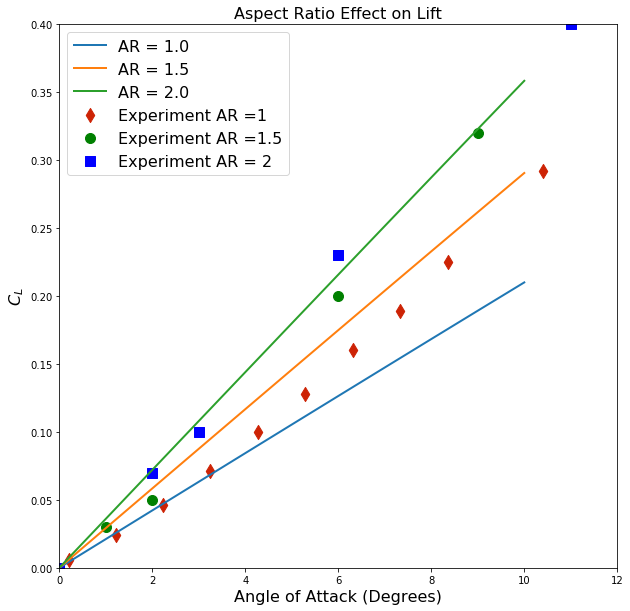

In [31]:
# importing experimental results 

#Aspect Ratio =1
AR1 = numpy.genfromtxt('./Resources/Delta_Exp_AR=1.csv', delimiter = ',')
alpha1 = AR1[:,0]
Cl1 = AR1[:,1]

# AspectRatio 1.5
AR1p5 = numpy.genfromtxt('./Resources/Delta_Exp_AR=1p5.csv',
                        delimiter = ',')
alpha1p5 = AR1p5[:,0]
Cl1p5 = AR1p5[:,1]

# Aspect Ration 2
AR2 = numpy.genfromtxt('./Resources/Delta_Exp_AR=2.csv', 
                      delimiter =',')
alpha2 = AR2[:,0]
Cl2 =AR2[:,1]

# Plotting the results 
pyplot.figure(figsize = (10,10))
pyplot.title('Aspect Ratio Effect on Lift', fontsize = 16)
pyplot.xlabel('Angle of Attack (Degrees)', fontsize = 16)
pyplot.ylabel('$C_L$', fontsize = 16)

pyplot.plot(alpha, Cl[0,:], linewidth = 2, linestyle = '-',
            label = ('AR = 1.0'))
pyplot.plot(alpha, Cl[1,:], linewidth =2, linestyle = '-', 
           label = 'AR = 1.5')
pyplot.plot(alpha, Cl[2, :], linewidth = 2, linestyle ='-', 
           label = 'AR = 2.0')

pyplot.scatter(alpha1, Cl1, color = '#CD2305', marker = 'd', s =100,
              label= 'Experiment AR =1')
pyplot.scatter(alpha1p5, Cl1p5, color = 'g', marker = 'o', s = 100,
              label ='Experiment AR =1.5')
pyplot.scatter(alpha2, Cl2, color = 'b', marker = 's', s = 100,
              label = 'Experiment AR = 2')
pyplot.legend(loc ='best', fontsize = 16)
pyplot.xlim(0, 12)
pyplot.ylim(0,0.4);

The experimental data agrees well at angles of attack less than 4 degrees. However, the error increases after that. Perhaps fixing the planar wing assumption to correct for higher angles of attack, this method would be an appropriate method to estimate the lift for Delta Wings 

## Limitations 

This model is a powerful, fast method for assessing the lift coefficent, however there are are some limitations of the model. 

1. Assumes the wing is infinitely thin
2. Assumes the wing is symmetric
3. Assumes the wing is planar, i.e. no cambering. This assumption is a large limitation for high angles of attack
4. The number of panels can cause problems and do not converge in some scenarios. 


## Future Steps

With this model, more relations can be explored for how sweep angle, tapering, angle of attack, and Type of wing can affect the lift coefficient. This can also be applied to a 3D model adding the effects of non-planar wings. Another way this model can be imporved on is the addition of the drag coefficient for each of the wing shapes.

## References 

1. Bertin, John J. and Smith, Michael L. Aerodynamics for Engineers, 3rd Edition. Prentice Hall, Upper Saddle, NJ, 1998. 

2. Anderson, John D. Fundamentals of Aerodynamics 3rd Edition. McGraw Hill, New York, NY. 2001. 

3. Weber, J. and Brebner, G. C., "Low Speed Tests on 45-deg Swept-Back Wings, Part I: Pressure Measurements on Wings of Aspect Ratio 5," *Reports and Memoranda 2882*, Aeronautical Research Council, 1958. 

4. Peckham, D. H., "Low Speed Wind-Tunnel Tests on a Series of Uncambered Slender Pointed Wings with Sharp Edges," *Reports and Memoranda 3186*, Aeronautical Research Council, Dec 1958.

5. Barlett, G. E., and Vidal, R. J., "Experimental Investigation of Influence of Edge Shape on the Aerodynamic Characteristics of Low Aspect Ratio Wings at Low Speeds," *Journal of the Aeronautical Sciences*, Aug 1995, Vol 22, No. 8, pp. 517-533, 588. 

In [26]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./Resources/custom.css", "r").read()
    return HTML(styles)
css_styling()